# Лабораторная работа 1

***Борисов Дмитрий Сергеевич (6233-010402D)***

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
import pandas as pd


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



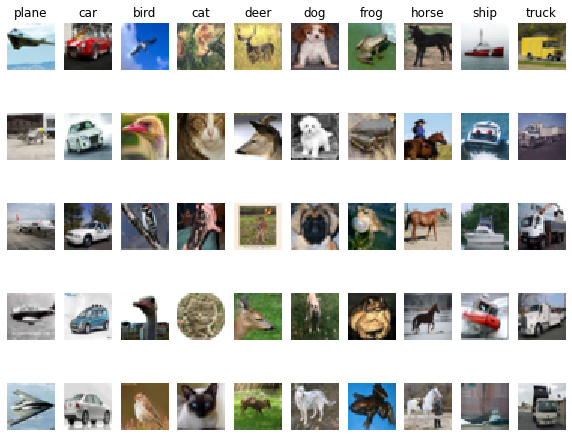

In [3]:
mapping_labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
n_classes = len(mapping_labels)
n_samples = 5

for class_index, class_name in enumerate(mapping_labels):
    class_indexes = np.random.choice(np.flatnonzero(y_train == class_index), n_samples, replace=False)
    for i, idx in enumerate(class_indexes):
        plt_idx = i * n_classes + class_index + 1
        plt.subplot(n_samples, n_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(class_name)
plt.show()

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [4]:
train_mask = range(5000)
knn_X_train = X_train[train_mask]
knn_y_train = y_train[train_mask]

test_mask = range(500)
knn_X_test = X_test[test_mask]
knn_y_test = y_test[test_mask]

In [5]:
knn_X_train = np.reshape(knn_X_train, (knn_X_train.shape[0], -1))
knn_y_train = np.reshape(knn_y_train, (knn_y_train.shape[0],))
knn_X_test = np.reshape(knn_X_test, (knn_X_test.shape[0], -1))
knn_y_test = np.reshape(knn_y_test, (knn_y_test.shape[0],))
print(knn_X_train.shape, knn_X_test.shape)

(5000, 3072) (500, 3072)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [6]:
from scripts.classifiers.k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(knn_X_train, knn_y_train)

1.5 Выполните классификацию на тестовой выборке

In [7]:
%%time
dists_one_loop = classifier.compute_distances_one_loop(knn_X_test)

Wall time: 38.4 s


In [8]:
%%time
dists_two_loops = classifier.compute_distances_two_loops(knn_X_test)

Wall time: 1min 20s


In [9]:
%%time
dists_no_loops = classifier.compute_distances_no_loops(knn_X_test)

Wall time: 9.54 s


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


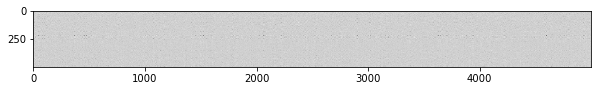

In [10]:
plt.imshow(dists_one_loop, interpolation='none')
plt.show()

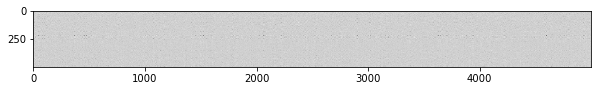

In [11]:
plt.imshow(dists_two_loops, interpolation='none')
plt.show()

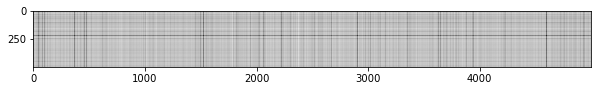

In [12]:
plt.imshow(dists_no_loops, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [13]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / np.sum(y_test.shape)

In [14]:
def print_accuracy(model, dists, text='accuracy: ', k=1):
    y_pred = model.predict_labels(dists, k=k)
    print(text, accuracy(knn_y_test, y_pred))

In [15]:
print_accuracy(classifier, dists_one_loop, "accuracy with one loop: ")

accuracy with one loop:  0.176


In [16]:
print_accuracy(classifier, dists_two_loops, "accuracy with two loops: ")

accuracy with two loops:  0.176


In [17]:
print_accuracy(classifier, dists_no_loops, "accuracy with no loops: ")

accuracy with no loops:  0.102


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

In [18]:
k_list = range(1, 10)
acc_dict = {'0 loops': [], '1 loop': [], '2 loops': []}

for k in k_list:
    y_preds_with_0_loops = classifier.predict(knn_X_test, k=k, num_loops=0)
    y_preds_with_1_loops = classifier.predict(knn_X_test, k=k, num_loops=1)
    y_preds_with_2_loops = classifier.predict(knn_X_test, k=k, num_loops=2)
    acc_dict['0 loops'].append(accuracy(y_preds_with_0_loops, knn_y_test))
    acc_dict['1 loop'].append(accuracy(y_preds_with_1_loops, knn_y_test))
    acc_dict['2 loops'].append(accuracy(y_preds_with_2_loops, knn_y_test))

In [19]:
acc_df = pd.DataFrame(acc_dict, index=k_list)
acc_df

,0 loops,1 loop,2 loops
1,0.102,0.176,0.176
2,0.114,0.188,0.188
3,0.102,0.208,0.208
4,0.114,0.210,0.210
5,0.116,0.200,0.200
6,0.114,0.230,0.230
7,0.114,0.216,0.216
8,0.114,0.226,0.226
9,0.114,0.226,0.226


<AxesSubplot:xlabel='k value'>

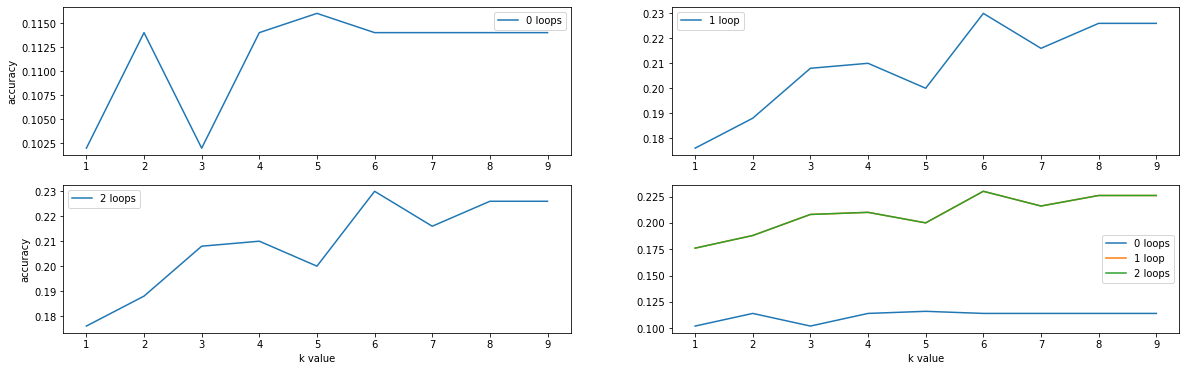

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 6))
acc_df.plot(y='0 loops', kind='line', ylabel='accuracy', ax=ax1)
acc_df.plot(y='1 loop', kind='line', ax=ax2)
acc_df.plot(y='2 loops', kind='line', xlabel='k value', ylabel='accuracy', ax=ax3)
acc_df.plot(xlabel='k value', ax=ax4)

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.

In [21]:
best_k_for_loops = acc_df.idxmax()
print(f"Best k for classification:\n", best_k_for_loops, sep='')

Best k for classification:
0 loops    5
1 loop     6
2 loops    6
dtype: int64



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [22]:
new_classifier = KNearestNeighbor()
new_classifier.train(knn_X_train, knn_y_train)

In [23]:
print_accuracy(new_classifier, dists_one_loop, "accuracy with one loop: ", 
               k=best_k_for_loops['1 loop'])

accuracy with one loop:  0.23


In [24]:
print_accuracy(new_classifier, dists_two_loops, "accuracy with two loops: ",
               k=best_k_for_loops['2 loops'])

accuracy with two loops:  0.23


In [25]:
print_accuracy(new_classifier, dists_no_loops, "accuracy with no loops: ",
               k=best_k_for_loops['0 loops'])

accuracy with no loops:  0.116


1.11 Сделайте выводы по результатам 1 части задания.

***Conclusion***: По результатам кросс-валидации по параметру k классификатора KNN удалось улучшить показатель accuracy c 0.176 до 0.23 для классификаций с 1 и 2 циклами, а также с 0.102 до 0.116 - для классификации без циклов.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [26]:
n_train = 49000
n_val = 1000
n_test = 9000

svm_X_train = X_train[range(n_train)]
svm_y_train = y_train[range(n_train)]

svm_X_val = X_train[range(n_train, n_train + n_val)]
svm_y_val = y_train[range(n_train, n_train + n_val)]

svm_X_test = X_test[range(n_test)]
svm_y_test = y_test[range(n_test)]

svm_X_dev = X_test[range(n_test, n_test + n_val)]
svm_y_dev = y_test[range(n_test, n_test + n_val)]

In [27]:
svm_X_train = np.reshape(svm_X_train, (svm_X_train.shape[0], -1), ).astype(np.float64)
svm_y_train = np.reshape(svm_y_train, (svm_y_train.shape[0],))

svm_X_val = np.reshape(svm_X_val, (svm_X_val.shape[0], -1)).astype(np.float64)
svm_y_val = np.reshape(svm_y_val, (svm_y_val.shape[0],))

svm_X_test = np.reshape(svm_X_test, (svm_X_test.shape[0], -1)).astype(np.float64)
svm_y_test = np.reshape(svm_y_test, (svm_y_test.shape[0],))

svm_X_dev = np.reshape(svm_X_dev, (svm_X_dev.shape[0], -1)).astype(np.float64)
svm_y_dev = np.reshape(svm_y_dev, (svm_y_dev.shape[0],))

In [28]:
#!pip install icecream

In [30]:
from icecream import ic

In [31]:
_ = ic(svm_X_train.shape, svm_y_train.shape, svm_X_val.shape, svm_y_val.shape,
   svm_X_test.shape, svm_y_test.shape, svm_X_dev.shape, svm_y_dev.shape)

ic| svm_X_train.shape: (49000, 3072)
    svm_y_train.shape: (49000,)
    svm_X_val.shape: (1000, 3072)
    svm_y_val.shape: (1000,)
    svm_X_test.shape: (9000, 3072)
    svm_y_test.shape: (9000,)
    svm_X_dev.shape: (1000, 3072)
    svm_y_dev.shape: (1000,)


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


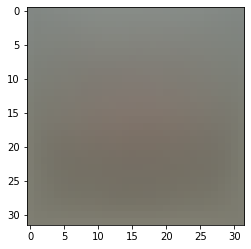

In [32]:
mean_image = np.mean(svm_X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

In [33]:
svm_X_train -= mean_image
svm_X_val -= mean_image
svm_X_test -= mean_image
svm_X_dev -= mean_image

svm_X_train = np.hstack([svm_X_train, np.ones((svm_X_train.shape[0], 1))])
svm_X_val = np.hstack([svm_X_val, np.ones((svm_X_val.shape[0], 1))])
svm_X_test = np.hstack([svm_X_test, np.ones((svm_X_test.shape[0], 1))])
svm_X_dev = np.hstack([svm_X_dev, np.ones((svm_X_dev.shape[0], 1))])

_ = ic(svm_X_train.shape, svm_X_val.shape, svm_X_test.shape, svm_X_dev.shape)

ic| svm_X_train.shape: (49000, 3073)
    svm_X_val.shape: (1000, 3073)
    svm_X_test.shape: (9000, 3073)
    svm_X_dev.shape: (1000, 3073)


2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [34]:
from scripts.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
import time

W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, svm_X_dev, svm_y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.415198



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [35]:
from scripts.gradient_check import grad_check_sparse

print("\nWihout reg\n")
loss, grad = svm_loss_naive(W, svm_X_dev, svm_y_dev, 0.0)
f = lambda w: svm_loss_naive(w, svm_X_dev, svm_y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print("\nWith reg\n")
loss, grad = svm_loss_naive(W, svm_X_dev, svm_y_dev, 5e1)
f = lambda w: svm_loss_naive(w, svm_X_dev, svm_y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)


Wihout reg

numerical: 13.215139 analytic: 0.000000, relative error: 1.000000e+00
numerical: 22.691369 analytic: 0.000000, relative error: 1.000000e+00
numerical: 9.330066 analytic: 0.000000, relative error: 1.000000e+00
numerical: -32.536712 analytic: 0.000000, relative error: 1.000000e+00
numerical: 14.315954 analytic: 0.000000, relative error: 1.000000e+00
numerical: -19.573830 analytic: 0.000000, relative error: 1.000000e+00
numerical: 28.303234 analytic: 0.000000, relative error: 1.000000e+00
numerical: 15.387793 analytic: 0.000000, relative error: 1.000000e+00
numerical: -1.906314 analytic: 0.000000, relative error: 1.000000e+00
numerical: -26.667298 analytic: 0.000000, relative error: 1.000000e+00

With reg

numerical: -17.548927 analytic: 0.000596, relative error: 1.000000e+00
numerical: -6.212507 analytic: -0.004190, relative error: 9.986521e-01
numerical: 16.462236 analytic: 0.000978, relative error: 9.998812e-01
numerical: 1.791325 analytic: 0.004121, relative error: 9.9540

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [36]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, svm_X_dev, svm_y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, svm_X_dev, svm_y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.081012s
Vectorized loss and gradient: computed in 0.135989s
difference: 3219.384658


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [37]:
from scripts.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(svm_X_train, svm_y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 405.593598
iteration 100 / 1500: loss 240.938495
iteration 200 / 1500: loss 146.575942
iteration 300 / 1500: loss 89.465072
iteration 400 / 1500: loss 56.532958
iteration 500 / 1500: loss 36.863851
iteration 600 / 1500: loss 23.395183
iteration 700 / 1500: loss 16.809668
iteration 800 / 1500: loss 11.513187
iteration 900 / 1500: loss 9.456741
iteration 1000 / 1500: loss 7.309291
iteration 1100 / 1500: loss 6.618041
iteration 1200 / 1500: loss 5.923938
iteration 1300 / 1500: loss 5.590127
iteration 1400 / 1500: loss 5.343812
That took 8.114899s


In [38]:
svm_y_train_pred = svm.predict(svm_X_train)
print('training accuracy: %f' % (np.mean(svm_y_train == svm_y_train_pred), ))
svm_y_val_pred = svm.predict(svm_X_val)
print('validation accuracy: %f' % (np.mean(svm_y_val == svm_y_val_pred), ))

training accuracy: 0.378061
validation accuracy: 0.393000


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [39]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]
iterations = 5
scores = {
          "learning_rate": [],
          "regularization_strength": [],
          "accuracies": [],
          "mean": [],
          "std": [],
          'max acc': []
        }

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        acc = []
        for iter in range(iterations):
            svm = LinearSVM()
            svm.train(svm_X_train, svm_y_train, 
                          learning_rate=learning_rate, 
                          reg=regularization_strength)
            svm_y_val_pred = svm.predict(svm_X_val)
            acc.append(np.mean(svm_y_val == svm_y_val_pred))
        scores["learning_rate"].append(learning_rate)
        scores["regularization_strength"].append(regularization_strength)
        scores["accuracies"].append(acc)
        scores["mean"].append(np.mean(acc))
        scores["std"].append(np.std(acc))
        scores["max acc"].append(np.max(acc))

In [40]:
scores_val = pd.DataFrame(scores).sort_values(by='mean', ascending=False)
scores_val

,learning_rate,regularization_strength,accuracies,mean,std,max acc
1,1.000000e-07,50000.0,"[0.237, 0.225, 0.252, 0.225, 0.237]",0.2352,0.009968,0.252
0,1.000000e-07,25000.0,"[0.234, 0.211, 0.214, 0.21, 0.237]",0.2212,0.011788,0.237
2,5.000000e-05,25000.0,"[0.137, 0.15, 0.14, 0.104, 0.156]",0.1374,0.018040,0.156
3,5.000000e-05,50000.0,"[0.063, 0.078, 0.051, 0.043, 0.044]",0.0558,0.013197,0.078


2.9 Сделайте выводы по второй части задания

***Conclusion***: 1) регуляризация может влиять на acccuracy SVM

2) На выбранных значениях гиперпараметрох из задания 2.8 резуьтат точности значительно ниже, чем на дефолтных значениях.